In [7]:
import pandas as pd
import torch
import torch.nn as nn
# import vaex
import numpy as np
import glob
import dask.dataframe as dd
import json
from sklearn.model_selection import train_test_split
import math
import csv
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import time
import _warnings
from tqdm import tqdm
import swifter
import argparse
import os
from copy import copy, deepcopy
from pathlib import Path
from concurrent import futures
from functools import partial
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})

/home/tiendat/miniconda3/envs/torchtf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# from collections import Counter
# from matplotlib import pyplot
# from numpy import where
# from imblearn.over_sampling import SMOTE, ADASYN
# from imblearn.over_sampling import KMeansSMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from collections import Counter
# from sklearn.cluster import MiniBatchKMeans


# epochs_number = 1  # number of epochs for the neural networks
# test_set_size = 0.2  # percentage of the test size comparing to the whole dataset
# oversampling_flag = 1  # set to 1 to over-sample the minority class
# oversampling_percentage = 0.2  # percentage of the minority class after the oversampling comparing to majority class

In [3]:
import sys
import os

%load_ext autoreload
%autoreload 2

sys.path.append('../')
sys.path.insert(0, os.path.dirname(os.getcwd()) + "/../")

print(sys.path)

['/home/tiendat/electric-theft-detection/../', '/home/tiendat/electric-theft-detection/notebooks', '/home/tiendat/miniconda3/envs/torchtf/lib/python39.zip', '/home/tiendat/miniconda3/envs/torchtf/lib/python3.9', '/home/tiendat/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/tiendat/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


# PREPROCESSING

In [2]:
# https://github.com/yvesheri4/Identification-of-Electricity-Theft

threshold = 31  # Set the threshold for NaN values

# Load the data
rawData = pd.read_csv('../data/data.csv')

infoData = pd.DataFrame()
infoData['FLAG'] = rawData['FLAG']
infoData['CONS_NO'] = rawData['CONS_NO']
data = rawData.drop(['FLAG', 'CONS_NO'], axis=1)  

# Process Data
# change column name to dates(2014/1/1 to 2014-01-01)
data.columns = pd.to_datetime(data.columns)  #columns reindexing according to dates
data = data.reindex(sorted(data.columns), axis=1)   # sort data accoding to date(as previusoly column are unsorted)

#droping duplicate row (31683 if not using)
dropIndex = data[data.duplicated()].index  # duplicates drop
data = data.drop(dropIndex, axis=0)   
infoData = infoData.drop(dropIndex, axis=0)

# Get index of rows with more than 600 NaNs
overthreshhold_index = data[data.isnull().sum(axis=1) > threshold].index  
data = data.drop(overthreshhold_index)
infoData = infoData.drop(overthreshhold_index, axis=0)

#removing row with all zero(Nan) value
zeroIndex = data[(data.sum(axis=1) == 0)].index  # zero rows drop
data = data.drop(zeroIndex, axis=0) 
infoData = infoData.drop(zeroIndex, axis=0) 

# reindex row name (as some row has been remove till this step due to duplicate or all nan values)
data.reset_index(inplace=True, drop=True)  # index sorting
infoData.reset_index(inplace=True, drop=True)

data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
2,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
3,5.20,2.35,2.56,1.46,2.04,5.38,2.73,0.16,3.28,8.03,...,12.02,13.50,9.45,8.81,10.24,15.89,13.00,14.80,14.91,9.03
4,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.83,0.02,0.06,0.58,0.89,0.35,0.38,0.70,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,23.26,24.57,24.25,0.00,23.79,20.93,20.59,25.95,18.52,19.00,...,8.64,8.00,13.02,8.40,10.21,8.61,7.03,8.41,9.84,8.69
15416,36.35,6.72,4.41,1.26,0.00,0.00,0.00,0.00,0.00,0.00,...,23.93,33.49,30.00,29.86,32.41,35.18,38.41,26.18,30.13,33.64
15417,2.03,2.82,1.93,2.13,1.81,2.91,1.73,1.53,1.93,1.32,...,2.29,1.54,2.13,2.05,2.80,2.29,2.22,2.34,2.52,1.84
15418,5.22,5.04,4.92,4.88,13.59,10.73,4.80,6.34,7.07,0.00,...,7.20,9.09,6.53,10.11,9.22,6.78,7.83,14.42,9.58,8.65


In [91]:
# df_complete = pd.concat([infoData, data], axis=1)

# df_complete[df_complete['FLAG'] == 1].shape, df_complete[df_complete['FLAG'] == 0].shape

((994, 1036), (14426, 1036))

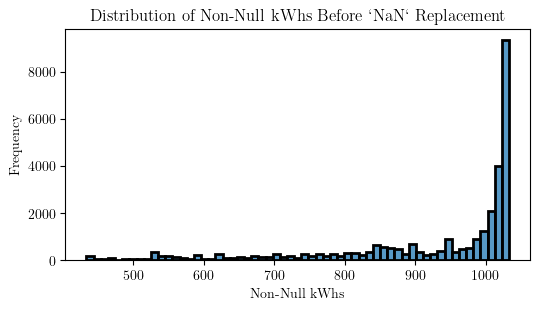

In [4]:
# Find's boolean mask of non-null values, then sums them by row - only checking kWhs
# non_null_counts_by_consumer = rawData.iloc[:, 2:].notnull().sum(axis=1)
non_null_counts_by_consumer = data.notnull().sum(axis=1)

# Print first five values to check
non_null_counts_by_consumer.head()

# Using a distribution plot to visualize non-null counts in data
plt.figure(figsize=(6, 3))
sns.histplot(non_null_counts_by_consumer, kde=False, edgecolor='k', linewidth=2)
plt.xlabel('Non-Null kWhs')
plt.ylabel('Frequency')
plt.title('Distribution of Non-Null kWhs Before `NaN` Replacement')

# Display the plot
plt.show()

In [7]:
max_by_consumer = data.max(axis=1)
average_by_consumer = data.mean(axis=1)
std_by_consumer = data.std(axis=1)

data.max().max(), data.mean().mean(), max_by_consumer.idxmax()

(800003.32, 9.649136149997538, 5240)

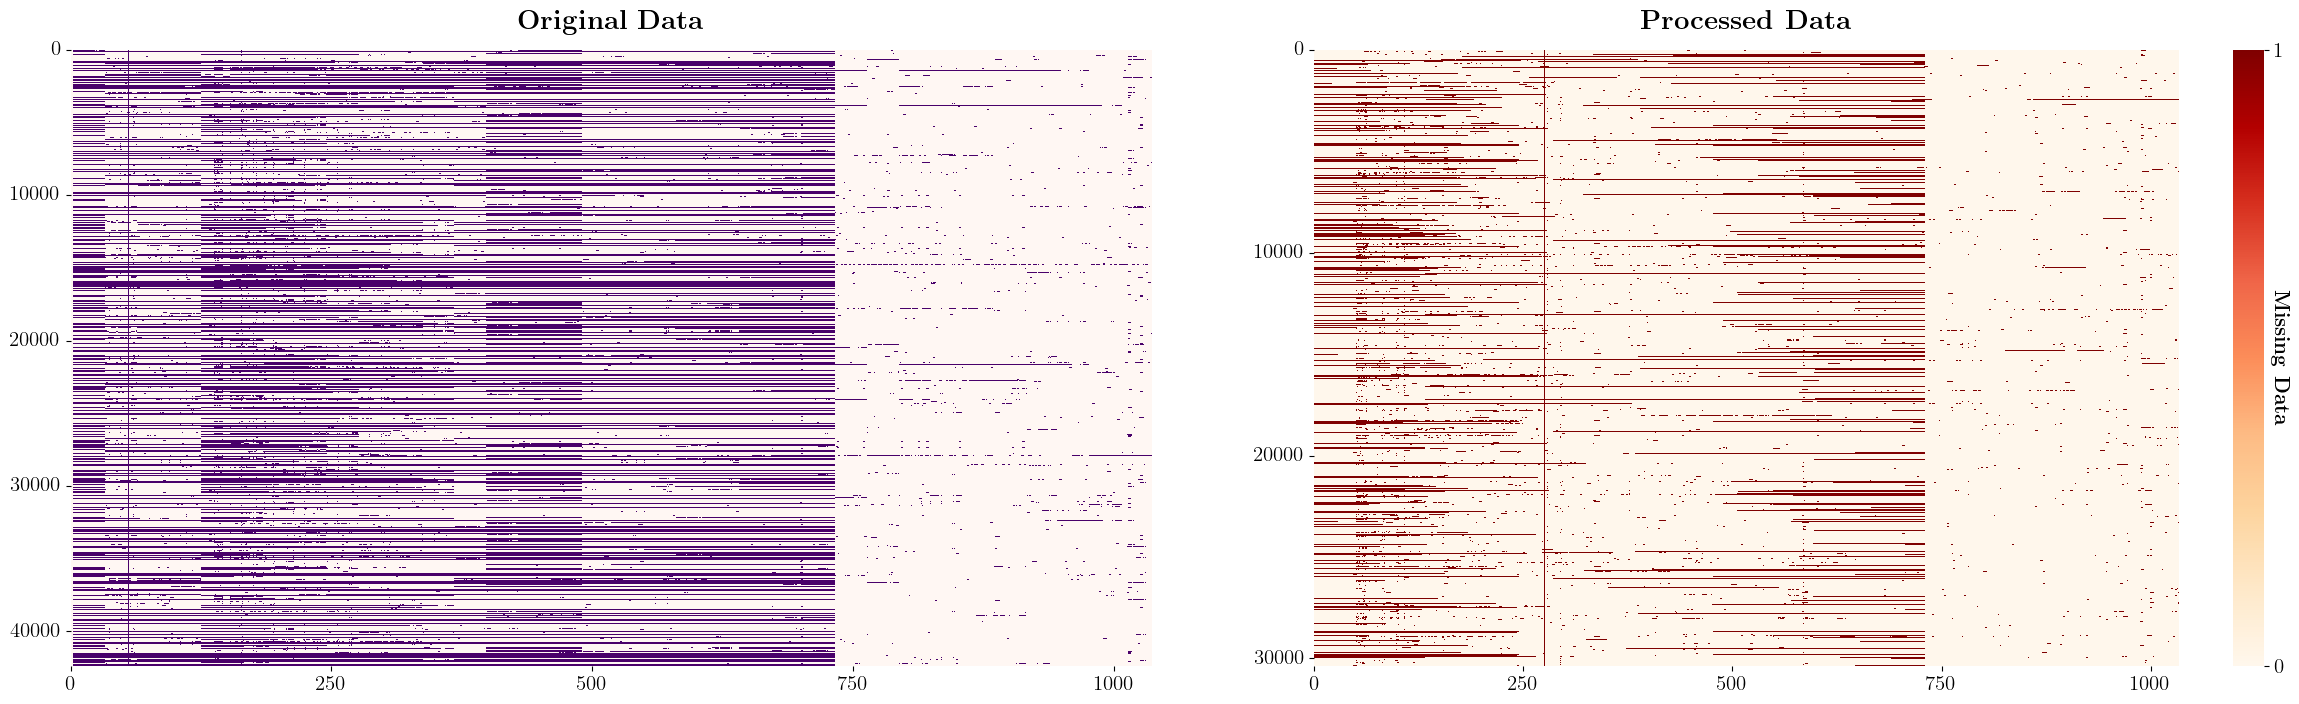

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(30,8))

sns.heatmap(rawData.transpose().isna().transpose(),
            cmap="RdPu", ax=axs[0], cbar=False)
axs[0].set_title(r'\textbf{Original Data}', fontsize=20, y=1.02)
axs[0].set_xticks([0, 250, 500,750,1000])
axs[0].set_xticklabels([0, 250, 500,750,1000], rotation=0, fontsize=15)
axs[0].set_yticks([0,10000, 20000, 30000, 40000])
axs[0].set_yticklabels([0, 10000, 20000, 30000, 40000], fontsize=15)

# cmap="OrRd"
cbar_ax = sns.heatmap(data.transpose().isna().transpose(),
            cmap="OrRd",
            cbar_kws={"ticks":[0,1]}, ax=axs[1]).collections[0].colorbar

# Set the label size of the colorbar
cbar_ax.ax.yaxis.set_tick_params(labelsize=15)
cbar_ax.set_label(r'\textbf{Missing Data}', rotation=-90, size=15)

axs[1].set_title(r'\textbf{Processed Data}', fontsize=20, y=1.02)
axs[1].set_xticks([0, 250, 500,750,1000])
axs[1].set_xticklabels([0, 250, 500,750,1000], rotation=0, fontsize=15)
axs[1].set_yticks([0,10000, 20000,30000])
axs[1].set_yticklabels([0,10000, 20000,30000], fontsize=15)

plt.subplots_adjust(wspace=0.15)
plt.show()

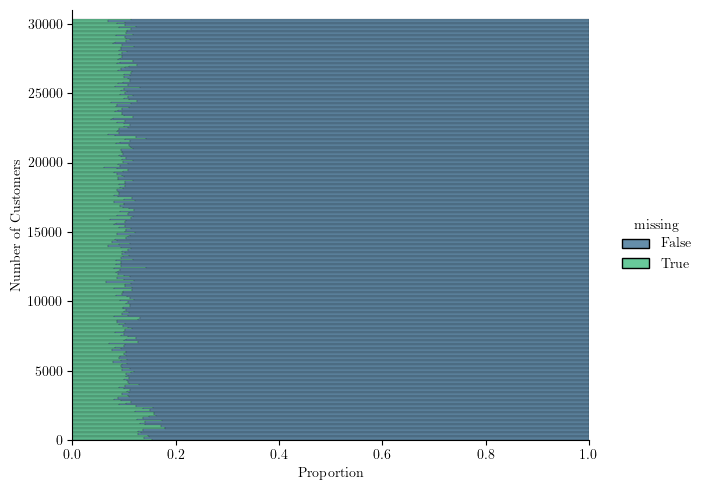

In [62]:
b=sns.displot(
    data=data.transpose().isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25,
    palette="viridis"
)
# b.set_xticklabels(size = 12)
# b.set_yticklabels(size = 12)
plt.xlabel('Proportion')
plt.ylabel('Number of Customers')
plt.ylim([0,31000])
plt.show()
# plt.savefig('missing_P.png')


In [10]:
balancing_data = data.copy(deep=True)
balancing_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
2,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
3,5.20,2.35,2.56,1.46,2.04,5.38,2.73,0.16,3.28,8.03,...,12.02,13.50,9.45,8.81,10.24,15.89,13.00,14.80,14.91,9.03
4,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.83,0.02,0.06,0.58,0.89,0.35,0.38,0.70,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,23.26,24.57,24.25,0.00,23.79,20.93,20.59,25.95,18.52,19.00,...,8.64,8.00,13.02,8.40,10.21,8.61,7.03,8.41,9.84,8.69
15416,36.35,6.72,4.41,1.26,0.00,0.00,0.00,0.00,0.00,0.00,...,23.93,33.49,30.00,29.86,32.41,35.18,38.41,26.18,30.13,33.64
15417,2.03,2.82,1.93,2.13,1.81,2.91,1.73,1.53,1.93,1.32,...,2.29,1.54,2.13,2.05,2.80,2.29,2.22,2.34,2.52,1.84
15418,5.22,5.04,4.92,4.88,13.59,10.73,4.80,6.34,7.07,0.00,...,7.20,9.09,6.53,10.11,9.22,6.78,7.83,14.42,9.58,8.65


# KNN Imputation testing


In [13]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Apply the KNN imputation only to the consumption columns (leave the label column as is)
imputer_result = knn_imputer.fit_transform(balancing_data)
imputer_result

array([[ 2.9 ,  5.64,  6.99, ..., 10.89,  9.86,  8.72],
       [ 0.11,  0.11,  0.25, ...,  1.34,  1.26,  1.4 ],
       [ 0.91,  1.16,  0.75, ...,  2.96,  3.67,  2.91],
       ...,
       [ 2.03,  2.82,  1.93, ...,  2.34,  2.52,  1.84],
       [ 5.22,  5.04,  4.92, ..., 14.42,  9.58,  8.65],
       [ 0.58,  1.16,  0.92, ...,  0.66,  0.39,  0.65]])

### Fill the missing values

In this work, we exploit the interpolation method to recover the missing values according to the following equation,

\begin{equation}
f(x_i)=
\begin{cases}
\frac{x_{i-1}+x_{i+1}}{2} \quad  x_i \in NaN,\;x_{i-1},x_{i+1} \notin NaN \\
0 \quad\quad\quad \;  x_i \in NaN,\;x_{i-1}\;or\; x_{i+1} \in NaN \\
x_i \quad \quad \quad  x_i \notin NaN
\end{cases}
\end{equation}

The interpolate() function uses existing values in the DataFrame to estimate the missing rows.

In [9]:
balancing_data = balancing_data.interpolate(method='linear', limit=2, limit_direction='both', axis=1).fillna(0)
balancing_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30358,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
30359,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
30360,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
30361,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [19]:
df_outliner_processed = pd.DataFrame(imputer_result, columns=data.columns)
df_outliner_processed

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
2,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
3,5.20,2.35,2.56,1.46,2.04,5.38,2.73,0.16,3.28,8.03,...,12.02,13.50,9.45,8.81,10.24,15.89,13.00,14.80,14.91,9.03
4,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.83,0.02,0.06,0.58,0.89,0.35,0.38,0.70,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,23.26,24.57,24.25,0.00,23.79,20.93,20.59,25.95,18.52,19.00,...,8.64,8.00,13.02,8.40,10.21,8.61,7.03,8.41,9.84,8.69
15416,36.35,6.72,4.41,1.26,0.00,0.00,0.00,0.00,0.00,0.00,...,23.93,33.49,30.00,29.86,32.41,35.18,38.41,26.18,30.13,33.64
15417,2.03,2.82,1.93,2.13,1.81,2.91,1.73,1.53,1.93,1.32,...,2.29,1.54,2.13,2.05,2.80,2.29,2.22,2.34,2.52,1.84
15418,5.22,5.04,4.92,4.88,13.59,10.73,4.80,6.34,7.07,0.00,...,7.20,9.09,6.53,10.11,9.22,6.78,7.83,14.42,9.58,8.65


In [20]:
last_col_name = df_outliner_processed.columns[-1]

df_outliner_processed['2016-11-01'] = df_outliner_processed[last_col_name]
df_outliner_processed['2016-11-02'] = df_outliner_processed[last_col_name]
df_outliner_processed

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31,2016-11-01,2016-11-02
0,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72,8.72,8.72
1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40,1.40,1.40
2,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91,2.91,2.91
3,5.20,2.35,2.56,1.46,2.04,5.38,2.73,0.16,3.28,8.03,...,9.45,8.81,10.24,15.89,13.00,14.80,14.91,9.03,9.03,9.03
4,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.06,0.58,0.89,0.35,0.38,0.70,0.25,0.25,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,23.26,24.57,24.25,0.00,23.79,20.93,20.59,25.95,18.52,19.00,...,13.02,8.40,10.21,8.61,7.03,8.41,9.84,8.69,8.69,8.69
15416,36.35,6.72,4.41,1.26,0.00,0.00,0.00,0.00,0.00,0.00,...,30.00,29.86,32.41,35.18,38.41,26.18,30.13,33.64,33.64,33.64
15417,2.03,2.82,1.93,2.13,1.81,2.91,1.73,1.53,1.93,1.32,...,2.13,2.05,2.80,2.29,2.22,2.34,2.52,1.84,1.84,1.84
15418,5.22,5.04,4.92,4.88,13.59,10.73,4.80,6.34,7.07,0.00,...,6.53,10.11,9.22,6.78,7.83,14.42,9.58,8.65,8.65,8.65


In [8]:
df_outliner_processed['label'] = infoData['FLAG']
df_outliner_processed

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,2016-10-23 00:00:00,2016-10-24 00:00:00,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00,label
0,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72,1
1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40,1
2,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91,1
3,5.20,2.35,2.56,1.46,2.04,5.38,2.73,0.16,3.28,8.03,...,13.50,9.45,8.81,10.24,15.89,13.00,14.80,14.91,9.03,1
4,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.83,0.02,0.06,0.58,0.89,0.35,0.38,0.70,0.25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,23.26,24.57,24.25,0.00,23.79,20.93,20.59,25.95,18.52,19.00,...,8.00,13.02,8.40,10.21,8.61,7.03,8.41,9.84,8.69,0
15416,36.35,6.72,4.41,1.26,0.00,0.00,0.00,0.00,0.00,0.00,...,33.49,30.00,29.86,32.41,35.18,38.41,26.18,30.13,33.64,0
15417,2.03,2.82,1.93,2.13,1.81,2.91,1.73,1.53,1.93,1.32,...,1.54,2.13,2.05,2.80,2.29,2.22,2.34,2.52,1.84,0
15418,5.22,5.04,4.92,4.88,13.59,10.73,4.80,6.34,7.07,0.00,...,9.09,6.53,10.11,9.22,6.78,7.83,14.42,9.58,8.65,0


In [44]:
import time

# Attempting numpy array-based solution
kWhs = data.values.copy()

# Does it have the right shape
rows, cols = kWhs.shape

# Record time at beginning of loop
t_0 = time.time()

# For every consumer
for i in range(0, rows):
  # Print a dot as an update after every 400 consumers
  if (i % 400  == 0):
    print("*", end="")

  # And for every value of that consumer
  for j in range(1, cols - 1):
    # If the current value is undefined
    if (np.isnan(kWhs[i, j])):
      if (~np.isnan(kWhs[i, j - 1]) and ~np.isnan(kWhs[i, j + 1])):
        kWhs[i, j] = np.mean([kWhs[i, j - 1], kWhs[i, j + 1]])
      elif(np.isnan(kWhs[i, j - 1]) or np.isnan(kWhs[i, j + 1])):
        kWhs[i, j] = 0.0

# Record time at end of loop
t_f = time.time()
print('\n', (t_f - t_0)/60)

****************************************************************************
 0.8445790489514668


In [16]:
outliner_processing = balancing_data.copy(deep=True)

# For testing purpose

In [107]:
import os
import numpy as np
import pandas as pd

# Directory containing the .npz files
directory = ['../data/non_ksm_transformer/train', '../data/non_ksm_transformer/val']

# List to hold the data


# Loop through all files in the directory
for dir in directory:
    data_list = []
    label_list = []
    for filename in os.listdir(dir):
        if filename.endswith('.npz'):
            # Load the .npz file
            file_path = os.path.join(dir, filename)
            with np.load(file_path) as data:
                # Assuming the .npz file contains arrays, extract them
                consump = data['X'] 
                label = data['y']
                
                data_list.append(consump.flatten().tolist())
                label_list.append(label.flatten().tolist()[0])
    if 'train' in dir:
        train_data = pd.DataFrame(data_list)
        train_data['label'] = label_list
    else:
        val_data = pd.DataFrame(data_list)
        val_data['label'] = label_list

train_data

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,4.96,4.40,5.68,7.87,5.55,6.62,7.85,0.0,0.0,0
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,1.74,1.91,1.81,2.16,1.89,1.98,1.89,0.0,0.0,0
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,2.37,3.01,2.90,2.88,3.97,2.72,3.25,0.0,0.0,0
3,9.34000,15.16000,14.40000,15.24000,14.63000,13.62000,13.01,15.39000,11.35000,8.08,...,11.86,13.60,17.86,13.38,14.01,11.20,12.91,0.0,0.0,1
4,0.77000,0.77000,0.68000,0.01000,0.10000,0.03000,0.09,0.04000,0.25000,0.84,...,1.27,1.54,1.70,0.98,0.75,1.33,0.56,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25342,0.25000,0.65000,1.53000,5.73000,5.26000,1.60000,0.99,1.18000,0.96000,1.10,...,11.66,11.54,10.69,11.24,11.08,9.14,10.12,0.0,0.0,0
25343,16.37371,16.37371,16.37371,16.37371,16.37371,16.37371,13.22,16.37371,16.37371,16.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1
25344,3.91000,5.59000,4.50000,5.31000,2.91000,3.98000,3.33,4.22000,6.38000,6.02,...,4.76,3.13,5.95,6.01,3.03,4.49,2.30,0.0,0.0,0
25345,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.0,0


In [4]:
threshold = 500 # if values are greater than 500, then it is an outlier

reducing_df = val_data.copy(deep=True)

df_outliner = reducing_df[(reducing_df > threshold).any(axis=1)]

df_outliner 

bool_df = df_outliner > threshold

outlier_threshold = 50 # if a sample has more than 50 columns with values greater than threshold, then we should keep it

count_per_column = bool_df.sum(axis=1)

drop_index = count_per_column[count_per_column < outlier_threshold].index
consider_index = count_per_column[count_per_column >= outlier_threshold].index

print(f"Shape: {consider_index.shape[0]} and total samples that have value more than threshold: {df_outliner.shape[0]}")

drop_if_overthreshold = []
for i in consider_index:
    if reducing_df.iloc[i].max() > 750: # if the max value of a sample is greater than 50000, then we should drop it
        # print(i)   
        drop_if_overthreshold.append(i)

drop_index = pd.Index(drop_index.tolist() + drop_if_overthreshold)

filtered_data = reducing_df.loc[consider_index]
print("Number of attack samples: ", filtered_data[filtered_data['label'] == 1].shape[0])
drop_index, consider_index

Shape: 7 and total samples that have value more than threshold: 18
Number of attack samples:  5


(Index([2127, 2254, 3213, 4068, 4351, 4835, 5369, 5641, 5666, 6086, 6170, 5459], dtype='int64'),
 Index([1031, 1225, 3186, 4226, 4339, 5459, 5546], dtype='int64'))

In [3]:
train_data_reduced = train_data.drop(drop_index, axis=0) 
train_data_reduced.reset_index(inplace=True, drop=True)
train_data_reduced

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,4.96,4.40,5.68,7.87,5.55,6.62,7.85,0.0,0.0,0
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,1.74,1.91,1.81,2.16,1.89,1.98,1.89,0.0,0.0,0
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,2.37,3.01,2.90,2.88,3.97,2.72,3.25,0.0,0.0,0
3,9.34000,15.16000,14.40000,15.24000,14.63000,13.62000,13.01,15.39000,11.35000,8.08,...,11.86,13.60,17.86,13.38,14.01,11.20,12.91,0.0,0.0,1
4,0.77000,0.77000,0.68000,0.01000,0.10000,0.03000,0.09,0.04000,0.25000,0.84,...,1.27,1.54,1.70,0.98,0.75,1.33,0.56,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25264,0.25000,0.65000,1.53000,5.73000,5.26000,1.60000,0.99,1.18000,0.96000,1.10,...,11.66,11.54,10.69,11.24,11.08,9.14,10.12,0.0,0.0,0
25265,16.37371,16.37371,16.37371,16.37371,16.37371,16.37371,13.22,16.37371,16.37371,16.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1
25266,3.91000,5.59000,4.50000,5.31000,2.91000,3.98000,3.33,4.22000,6.38000,6.02,...,4.76,3.13,5.95,6.01,3.03,4.49,2.30,0.0,0.0,0
25267,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.0,0


In [5]:
val_data_reduced = val_data.drop(drop_index, axis=0) 
val_data_reduced.reset_index(inplace=True, drop=True)
val_data_reduced

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,132.57,143.01,131.51,131.15,114.89,114.94,114.00,0.0,0.0,1
1,0.03,0.01,0.01,0.01,0.00,0.01,0.00,0.01,0.01,0.01,...,5.12,2.93,3.47,2.69,0.08,0.08,3.84,0.0,0.0,0
2,16.97,15.08,15.86,13.36,15.19,13.43,12.50,14.05,15.00,12.30,...,17.91,19.19,18.06,21.84,20.35,17.41,16.76,0.0,0.0,0
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.95,2.30,2.48,1.86,1.77,2.25,1.80,0.0,0.0,0
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.64,2.07,2.70,2.68,2.15,1.62,1.77,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6319,0.00,4.15,0.00,5.73,6.80,8.27,6.11,5.69,5.61,6.05,...,8.77,10.68,8.42,9.18,8.39,10.20,8.43,0.0,0.0,0
6320,5.18,6.86,0.00,0.00,0.00,7.54,5.07,0.00,7.55,0.00,...,15.15,11.42,12.64,11.80,13.09,8.22,0.00,0.0,0.0,0
6321,9.79,9.63,7.85,8.49,8.75,8.23,8.80,5.91,10.14,8.60,...,6.64,7.10,8.54,7.66,7.27,7.42,6.36,0.0,0.0,0
6322,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.27,0.13,0.26,0.21,0.17,0.26,0.22,0.0,0.0,0


In [ ]:
outliner_processing = outliner_processing.drop(drop_index, axis=0) 
outliner_processing.reset_index(inplace=True, drop=True)
outliner_processing

In [40]:
df_outliers_handled = train_data_reduced.iloc[:, :-3].copy(deep=True)

for i in range(df_outliers_handled.shape[0]):
    i = 20920
    mean = df_outliers_handled.loc[i].mean()
    max = df_outliers_handled.loc[i].max()
    min = df_outliers_handled.loc[i].min()
    sd = df_outliers_handled.loc[i].std()
    Q1 = df_outliers_handled.loc[i].quantile(0.25)
    Q3 = df_outliers_handled.loc[i].quantile(0.75)
    IQR = Q3 - Q1
    
    # upper_limit = Q3 + 3 * IQR
    # lower_limit = Q1 - 3 * IQR
    
    upper_limit = mean + 2 * sd
    lower_limit = mean - 2 * sd
    
    # print(df_outliers_handled.loc[i].describe())    
    # print(f"Row: {i}, IQR: {IQR}, \nUpper Threshold: {upper_threshold}, Lower Threshold: {lower_threshold}, \nUpper Limit: {upper_limit}, Lower Limit: {lower_limit}")
    
    # print(f"Row: {i}, Max: {max}, Mean: {mean}, SD: {sd}, Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, \nUpper Threshold: {upper_threshold}, Lower Threshold: {lower_threshold}, \nUpper Limit: {upper_limit}, Lower Limit: {lower_limit}")
    
    # Capping the data at the upper and lower sigma limits.
    df_outliers_handled.loc[i] = np.where(df_outliers_handled.loc[i] > upper_limit, upper_limit, 
                                          np.where(df_outliers_handled.loc[i] < lower_limit, lower_limit, df_outliers_handled.loc[i]))


In [103]:
generated_data = np.load('../data/GAN_data.npz', allow_pickle=True)

consump = generated_data['data']
label = generated_data['label']

GAN_gen = pd.DataFrame(consump)

# Map each row to a flattened list
GAN_gen = GAN_gen.applymap(lambda x: x.flatten().tolist())

# Create a new DataFrame from the list of numbers in column 0
expanded_cols = pd.DataFrame(GAN_gen[0].tolist())

# Concatenate the new DataFrame with the original DataFrame, excluding the original column 0
GAN_gen = pd.concat([expanded_cols, pd.Series(label.flatten(), name='label')], axis=1)

# Display the resulting DataFrame
(GAN_gen)


,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,-0.088829,-0.118473,-0.532524,-0.137126,-0.469312,0.073411,-0.282871,-0.201974,-0.504203,-0.125954,...,1.000000,0.999990,1.000000,1.0,1.0,1.000000,1.0,0.999999,0.999963,1
1,-0.092591,-0.135492,-0.512242,-0.157723,-0.463422,0.070891,-0.291578,-0.232433,-0.498596,-0.118214,...,1.000000,0.999968,1.000000,1.0,1.0,0.999998,1.0,0.999996,0.999914,1
2,-0.092742,-0.127769,-0.487046,-0.185746,-0.444988,0.047448,-0.285288,-0.222451,-0.491471,-0.138255,...,0.999999,0.999696,0.999996,1.0,1.0,0.999964,1.0,0.999951,0.999608,1
3,-0.091001,-0.118655,-0.520867,-0.160478,-0.459225,0.055880,-0.294246,-0.220062,-0.501575,-0.127476,...,0.999998,0.999629,0.999995,1.0,1.0,0.999963,1.0,0.999952,0.999618,1
4,-0.086780,-0.116401,-0.512737,-0.156463,-0.458639,0.063168,-0.288402,-0.214416,-0.493559,-0.114381,...,1.000000,0.999948,1.000000,1.0,1.0,0.999997,1.0,0.999995,0.999887,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,-0.088421,-0.120412,-0.518539,-0.164416,-0.459195,0.063805,-0.283560,-0.215556,-0.497386,-0.117654,...,1.000000,0.999911,1.000000,1.0,1.0,0.999992,1.0,0.999987,0.999773,1
21259,-0.089814,-0.125722,-0.537024,-0.148756,-0.473545,0.077761,-0.302116,-0.213574,-0.505377,-0.118408,...,1.000000,0.999949,1.000000,1.0,1.0,0.999996,1.0,0.999992,0.999863,1
21260,-0.092248,-0.133813,-0.499542,-0.184745,-0.459078,0.055193,-0.280024,-0.232312,-0.494176,-0.127085,...,1.000000,0.999978,1.000000,1.0,1.0,0.999999,1.0,0.999998,0.999942,1
21261,-0.087611,-0.108715,-0.535779,-0.136854,-0.466452,0.086332,-0.281463,-0.199608,-0.491325,-0.108682,...,1.000000,0.999936,1.000000,1.0,1.0,0.999996,1.0,0.999991,0.999824,1


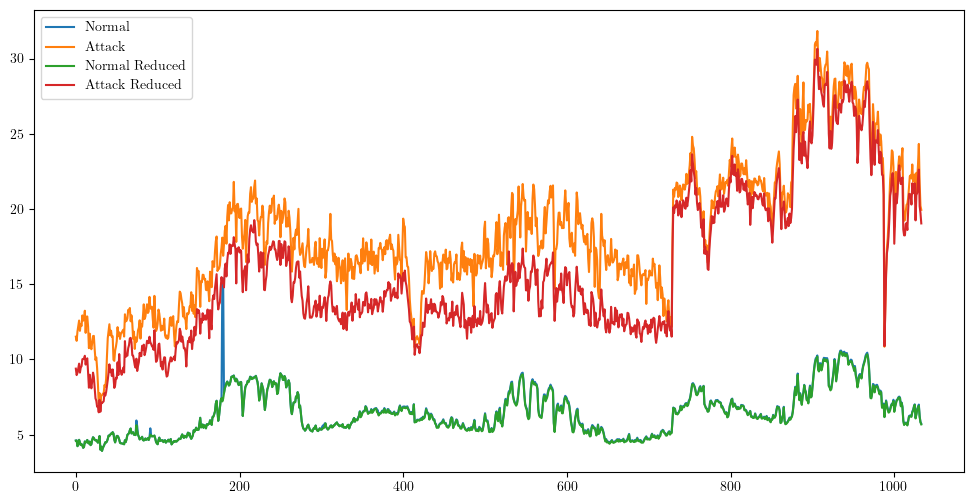

In [11]:
plt.figure(figsize=(12, 6))

visualize_df = val_data.copy(deep=True) 

attack_df = visualize_df[visualize_df['label'] == 1]
normal_df = visualize_df[visualize_df['label'] == 0]

# Calculate the average (mean) value per column
average_values_normal = normal_df.iloc[:, :-3].mean()
average_values_attack = attack_df.iloc[:, :-3].mean()

# Plot the Series
average_values_normal.plot(label='Normal')
average_values_attack.plot(label='Attack')

# For reduced

visualize_df = val_data_reduced.copy(deep=True)

attack_df = visualize_df[visualize_df['label'] == 1]
normal_df = visualize_df[visualize_df['label'] == 0]

# Calculate the average (mean) value per column
average_values_normal = normal_df.iloc[:, :-3].mean()
average_values_attack = attack_df.iloc[:, :-3].mean()

# Plot the Series

average_values_normal.plot(label='Normal Reduced')
average_values_attack.plot(label='Attack Reduced')

plt.legend()    

# Show the plot
plt.show()

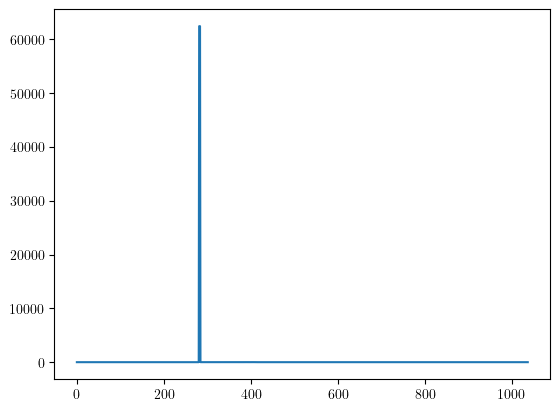

In [108]:
max_by_consumer = train_data.iloc[:, :-3].max(axis=1)

train_data.iloc[max_by_consumer.idxmax()].plot()

plt.show()  

In [16]:
import pandas as pd
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN

# Assuming train_data is already loaded and contains features and a target column 'label'
# Separate features and target
X = train_data_reduced.iloc[:, :-3]
y = train_data_reduced['label']

X_val = val_data_reduced.iloc[:, :-3]
y_val = val_data_reduced['label']

# Apply Borderline-SMOTE
smote = BorderlineSMOTE(random_state=42)
smote_enn = SMOTEENN(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X, y)

X_resampled_val, y_resampled_val = smote.fit_resample(X_val, y_val)
X_resampled_enn_val, y_resampled_enn_val = smote_enn.fit_resample(X_val, y_val)


# Create synthetic_data using pd.concat
synthetic_data = pd.concat([pd.DataFrame(X_resampled[len(X):], columns=X.columns), 
                            pd.Series(y_resampled[len(X):], name='label')], axis=1)

# Create synthetic_data_enn using pd.concat
synthetic_data_enn = pd.concat([pd.DataFrame(X_resampled_enn[len(X):], columns=X.columns), 
                                pd.Series(y_resampled_enn[len(X):], name='label')], axis=1)

# Create synthetic_data_val using pd.concat
synthetic_data_val = pd.concat([pd.DataFrame(X_resampled_val[len(X_val):], columns=X_val.columns), 
                                pd.Series(y_resampled_val[len(X_val):], name='label')], axis=1)

# Create synthetic_data_enn_val using pd.concat
synthetic_data_enn_val = pd.concat([pd.DataFrame(X_resampled_enn_val[len(X_val):], columns=X_val.columns), 
                                    pd.Series(y_resampled_enn_val[len(X_val):], name='label')], axis=1)


# Calculate the average (mean) value per column
average_values_normal = normal_df.iloc[:, :-3].mean()
average_values_attack = attack_df.iloc[:, :-3].mean()
avarage_values_generated = synthetic_data.iloc[:, :-1].mean()
avarage_values_generated_enn = synthetic_data_enn.iloc[:, :-1].mean()

average_values_normal_val = normal_df.iloc[:, :-3].mean()
average_values_attack_val = attack_df.iloc[:, :-3].mean()
avarage_values_generated_val = synthetic_data_val.iloc[:, :-1].mean()
avarage_values_generated_enn_val = synthetic_data_enn_val.iloc[:, :-1].mean()

In [79]:
train_data_reduced[train_data_reduced['label'] == 1].shape, train_data_reduced[train_data_reduced['label'] == 0].shape

((2003, 1037), (23266, 1037))

In [ ]:
generated_train_df = pd.concat([synthetic_data, train_data_reduced], axis=0)

In [104]:
average_GAN_gen = GAN_gen.iloc[:, :-3].mean()

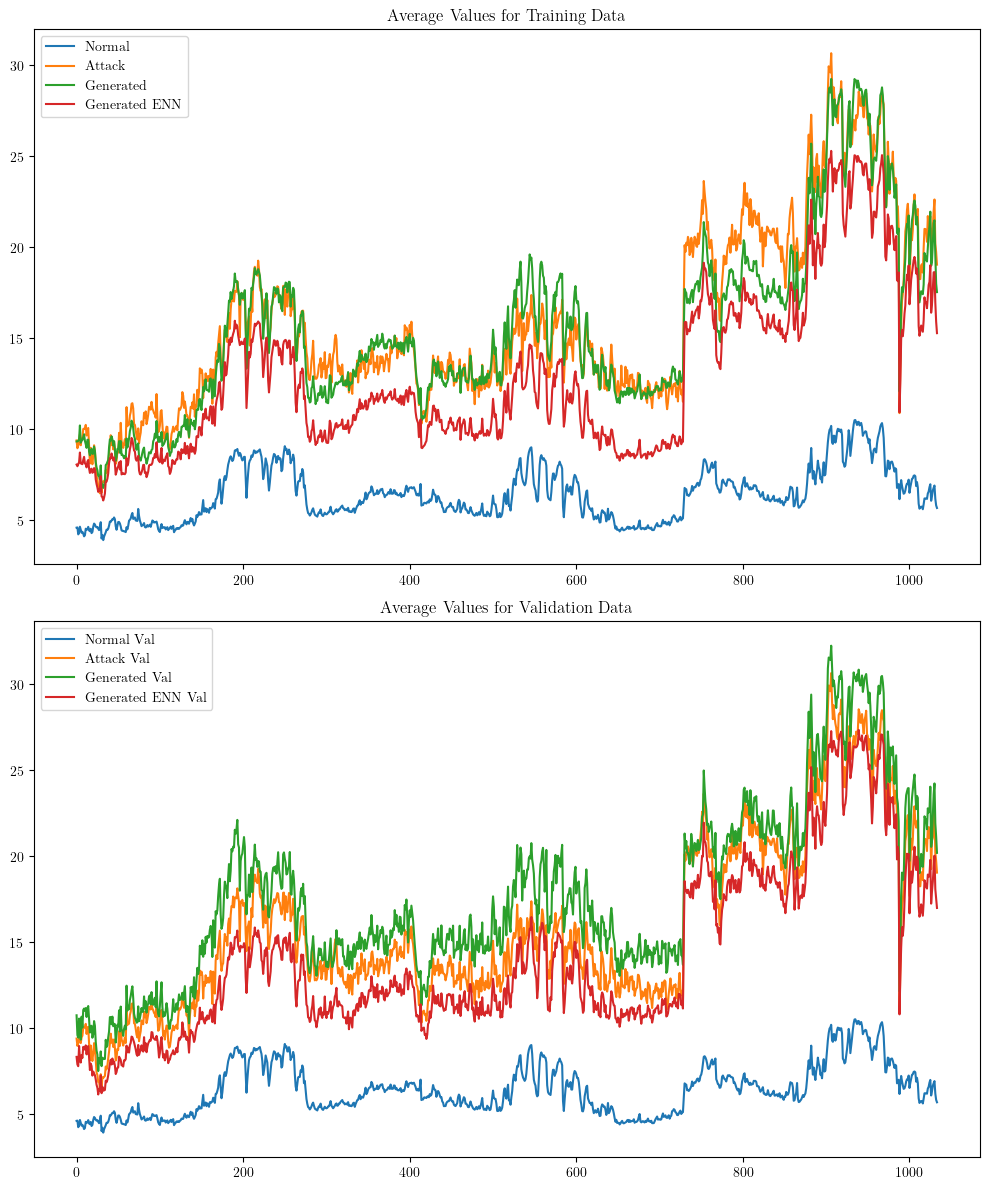

In [111]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plot the first set of average values
axes[0].plot(average_values_normal, label='Normal')
axes[0].plot(average_values_attack, label='Attack')
axes[0].plot(avarage_values_generated, label='Generated')
axes[0].plot(avarage_values_generated_enn, label='Generated ENN')
# axes[0].plot(average_GAN_gen, label='GAN gen')
axes[0].set_title('Average Values for Training Data')
axes[0].legend()

# Plot the second set of average values
axes[1].plot(average_values_normal_val, label='Normal Val')
axes[1].plot(average_values_attack_val, label='Attack Val')
axes[1].plot(avarage_values_generated_val, label='Generated Val')
axes[1].plot(avarage_values_generated_enn_val, label='Generated ENN Val')
axes[1].set_title('Average Values for Validation Data')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

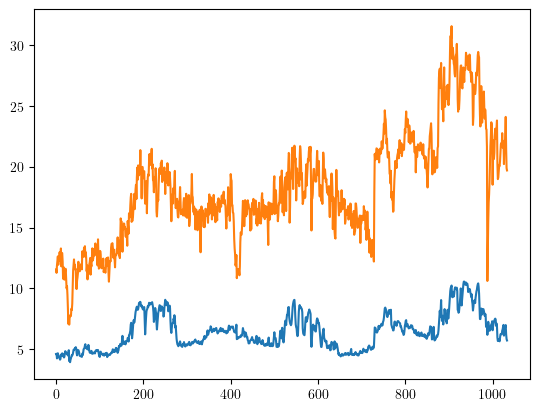

In [241]:
attack_df_2 = val_data_reduced[val_data_reduced['label'] == 1]
normal_df_2 = val_data_reduced[val_data_reduced['label'] == 0]

# Calculate the average (mean) value per column
average_values_normal_2 = normal_df_2.iloc[:, :-3].mean()
average_values_attack_2 = attack_df_2.iloc[:, :-3].mean()

# Plot the Series
average_values_normal_2.plot()
average_values_attack_2.plot()

# Show the plot
plt.show()

In [81]:
outliner_processing_df = train_data_reduced.iloc[:, :-3]
outliner_processing_df['label'] = train_data['label']
outliner_processing_df

#df_pr['data'] = df_pr[df_pr.columns].astype(float).values.tolist()
# outliner_processing_df['data'] = outliner_processing_df[outliner_processing_df.columns].values.tolist()
# df_apr_reducing = outliner_processing_df['data']

# df_apr_reducing

,0,1,2,3,4,5,6,7,8,9,...,1025,1026,1027,1028,1029,1030,1031,1032,1033,label
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,4.35,5.74,4.96,4.40,5.68,7.87,5.55,6.62,7.85,0
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,1.98,1.94,1.74,1.91,1.81,2.16,1.89,1.98,1.89,0
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,2.43,2.35,2.37,3.01,2.90,2.88,3.97,2.72,3.25,0
3,9.34000,15.16000,14.40000,15.24000,14.63000,13.62000,13.01,15.39000,11.35000,8.08,...,14.45,16.44,11.86,13.60,17.86,13.38,14.01,11.20,12.91,1
4,0.77000,0.77000,0.68000,0.01000,0.10000,0.03000,0.09,0.04000,0.25000,0.84,...,1.26,2.29,1.27,1.54,1.70,0.98,0.75,1.33,0.56,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24212,0.25000,0.65000,1.53000,5.73000,5.26000,1.60000,0.99,1.18000,0.96000,1.10,...,9.28,13.57,11.66,11.54,10.69,11.24,11.08,9.14,10.12,0
24213,16.37371,16.37371,16.37371,16.37371,16.37371,16.37371,13.22,16.37371,16.37371,16.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
24214,3.91000,5.59000,4.50000,5.31000,2.91000,3.98000,3.33,4.22000,6.38000,6.02,...,5.28,4.18,4.76,3.13,5.95,6.01,3.03,4.49,2.30,0
24215,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0


In [17]:

df_melted = df_outliner_processed.melt(id_vars=['label'], value_vars=df_outliner_processed.columns[:-1], var_name='day', value_name='consumption')
df_melted

,label,day,consumption
0,1,2014-01-01 00:00:00,2.90
1,1,2014-01-01 00:00:00,0.11
2,1,2014-01-01 00:00:00,0.91
3,1,2014-01-01 00:00:00,5.20
4,1,2014-01-01 00:00:00,0.00
...,...,...,...
15944275,0,2016-10-31 00:00:00,8.69
15944276,0,2016-10-31 00:00:00,33.64
15944277,0,2016-10-31 00:00:00,1.84
15944278,0,2016-10-31 00:00:00,8.65


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample data generation (replace this with your actual dataset)
# Assuming the dataset has columns 'user_type' and 'consumption'
# data = {
#     'user_type': ['Theft User'] * 500 + ['Normal User'] * 500,
#     'consumption': np.concatenate([np.random.normal(15, 5, 500), np.random.normal(7, 2, 500)])
# }

# Define the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

normal_df_plot =  df_melted.groupby('label').get_group(0)
attack_df_plot =  df_melted.groupby('label').get_group(1)

# Plotting Minor outliers comparison (using 1.5 IQR)
sns.boxplot(x='label', y='consumption', data=normal_df_plot, ax=axes[0], whis=1.5, showmeans=True, 
            meanprops={"marker":"D","markerfacecolor":"black", "markeredgecolor":"black"}, 
            flierprops={"marker":"o","markerfacecolor":"red", "markersize":4})
axes[0].set_title('(a) Minor outliers comparison')
axes[0].set_ylabel('Daily Energy Consumption (kWh)')

# Plotting Extreme outliers comparison (using 3 IQR)
sns.boxplot(x='label', y='consumption', data=normal_df_plot, ax=axes[1], whis=3, showmeans=True, 
            meanprops={"marker":"D","markerfacecolor":"black", "markeredgecolor":"black"}, 
            flierprops={"marker":"o","markerfacecolor":"red", "markersize":4})
axes[1].set_title('(b) Extreme outliers comparison')
axes[1].set_ylabel('Daily Energy Consumption (kWh)')

# Adjust the layout for clarity
plt.tight_layout()
plt.show()

In [23]:
df_melted.groupby('label')['consumption'].describe()    

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,14916484.0,8.341313,33.078508,0.0,1.25,4.93,9.74,53532.00
1,1027796.0,22.775210,523.381300,0.0,2.19,6.78,14.97,514991.78


In [ ]:
Q1 = df_melted.groupby('label')['consumption'].quantile(0.25)
Q3 = df_melted.groupby('label')['consumption'].quantile(0.75)
IQR = Q3 - Q1

mean = df_melted.groupby('label')['consumption'].mean()
std = df_melted.groupby('label')['consumption'].std()

min_threshold = mean - 3 * std
max_threshold = mean + 3 * std

extreme_outlier_min = Q1 - 3 * IQR
extreme_outlier_max = Q3 + 3 * IQR

extreme_outlier_min, extreme_outlier_max, min_threshold, max_threshold

In [23]:
max_by_consumer = outliner_processing.max(axis=1)
average_by_consumer = outliner_processing.mean(axis=1)
std_by_consumer = outliner_processing.std(axis=1)
min_by_consumer = outliner_processing.min(axis=1)

max_by_consumer.mean(), average_by_consumer.mean(), std_by_consumer.mean(), min_by_consumer.mean()  

(34.7369918823884, 7.957107803473322, 5.682359762587021, 0.004576537959211012)

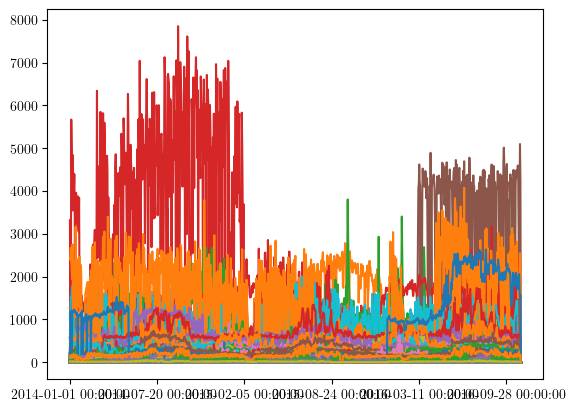

In [24]:
list_check = balancing_data[(balancing_data >= 100000).any(axis=1)].max(axis=1).index.tolist()

for i in outliner_processing.index:
    # if balancing_data.iloc[i].mean() < 2:
    #     print(i)
    if i in [2064, 2384]:
        continue
    outliner_processing.iloc[i].plot()
plt.show()

In [299]:
train_data_reduced.to_csv('../data/GAN_training.csv', index=False)

In [22]:
sampled_train_df = X_resampled.copy(deep=True)
sampled_train_df['label'] = y_resampled

sampled_val_df = X_resampled_val.copy(deep=True)
sampled_val_df['label'] = y_resampled_val

sampled_train_df

,0,1,2,3,4,5,6,7,8,9,...,1025,1026,1027,1028,1029,1030,1031,1032,1033,label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.350000,5.740000,4.960000,4.400000,5.680000,7.870000,5.550000,6.620000,7.850000,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.980000,1.940000,1.740000,1.910000,1.810000,2.160000,1.890000,1.980000,1.890000,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.430000,2.350000,2.370000,3.010000,2.900000,2.880000,3.970000,2.720000,3.250000,0
3,9.340000,15.160000,14.400000,15.240000,14.630000,13.620000,13.010000,15.390000,11.350000,8.080000,...,14.450000,16.440000,11.860000,13.600000,17.860000,13.380000,14.010000,11.200000,12.910000,1
4,0.770000,0.770000,0.680000,0.010000,0.100000,0.030000,0.090000,0.040000,0.250000,0.840000,...,1.260000,2.290000,1.270000,1.540000,1.700000,0.980000,0.750000,1.330000,0.560000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19.586791,14.993924,17.232051,15.968152,16.811525,19.094899,16.009864,13.892228,13.878351,1
46528,0.858271,1.534041,1.247081,2.083287,2.178506,1.667847,1.555345,1.140557,1.385561,1.444148,...,1.809696,3.604039,2.235136,2.160570,2.725795,2.570684,3.024060,2.815687,2.550032,1
46529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,172.396065,81.752950,84.016236,119.176771,144.568524,117.643038,103.034486,94.376557,72.263587,1
46530,7.878199,5.006447,5.638149,5.068679,7.814314,5.938965,4.894601,4.088598,3.268816,4.702146,...,4.157986,5.255904,4.839526,3.420623,4.745586,5.596265,6.046483,3.594894,4.922930,1


In [286]:
df_outliers_handled = train_data_reduced.copy(deep=True)
train_label = df_outliers_handled['label']
train_reduced_df = df_outliers_handled.drop(['label'], axis=1)

df_outliers_handled = val_data_reduced.copy(deep=True)
val_label = df_outliers_handled['label']
val_reduced_df = df_outliers_handled.drop(['label'], axis=1)

# df_outliers_handled = X_resampled.copy(deep=True)
# label = y_resampled

train_reduced_df

,0,1,2,3,4,5,6,7,8,9,...,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,5.74,4.96,4.40,5.68,7.87,5.55,6.62,7.85,0.0,0.0
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,1.94,1.74,1.91,1.81,2.16,1.89,1.98,1.89,0.0,0.0
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,2.35,2.37,3.01,2.90,2.88,3.97,2.72,3.25,0.0,0.0
3,9.34000,15.16000,14.40000,15.24000,14.63000,13.62000,13.01,15.39000,11.35000,8.08,...,16.44,11.86,13.60,17.86,13.38,14.01,11.20,12.91,0.0,0.0
4,0.77000,0.77000,0.68000,0.01000,0.10000,0.03000,0.09,0.04000,0.25000,0.84,...,2.29,1.27,1.54,1.70,0.98,0.75,1.33,0.56,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25204,0.25000,0.65000,1.53000,5.73000,5.26000,1.60000,0.99,1.18000,0.96000,1.10,...,13.57,11.66,11.54,10.69,11.24,11.08,9.14,10.12,0.0,0.0
25205,16.37371,16.37371,16.37371,16.37371,16.37371,16.37371,13.22,16.37371,16.37371,16.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0
25206,3.91000,5.59000,4.50000,5.31000,2.91000,3.98000,3.33,4.22000,6.38000,6.02,...,4.18,4.76,3.13,5.95,6.01,3.03,4.49,2.30,0.0,0.0
25207,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.0


In [23]:
for i in range(df_outliers_handled.shape[0]):
    mean = df_outliers_handled.loc[i].mean()
    sd = df_outliers_handled.loc[i].std()
    Q1 = df_outliers_handled.loc[i].quantile(0.25)
    Q3 = df_outliers_handled.loc[i].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_limit = Q3 + 3 * IQR
    lower_limit = Q1 - 3 * IQR
    
    # upper_limit = mean + 2 * sd
    # lower_limit = mean - 2 * sd
    
    # print(f"Row: {i}, Mean: {mean}, SD: {sd}, Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, \nUpper Threshold: {upper_threshold}, Lower Threshold: {lower_threshold}, \nUpper Limit: {upper_limit}, Lower Limit: {lower_limit}")
    
    # Capping the data at the upper and lower sigma limits.
    df_outliers_handled.loc[i] = np.where(df_outliers_handled.loc[i] > upper_limit, upper_limit, 
                                          np.where(df_outliers_handled.loc[i] < lower_limit, lower_limit, df_outliers_handled.loc[i]))


### Handling the outliers

We restore the value by following equation according to "Three-sigma rule of dumb"

\begin{equation}
f(x_i)=
\begin{cases}
avg(\mathbf{x})+3\cdot std(\mathbf{x}) \quad  if \; x_i > avg(\mathbf{x})+3\cdot std(\mathbf{x})\\
x_i \quad \quad \quad otherwise
\end{cases}
\end{equation}

### Z-Score: 
Calculate the z-score for each data point. Data points with a z-score greater than a certain threshold (e.g., 3 or -3) are considered outliers.

### IQR Method: 
Calculate the interquartile range (IQR). Data points outside the range [Q1 - 1.5IQR, Q3 + 1.5IQR] are considered outliers.

### Visualization: 
Use box plots, scatter plots, or histograms to visually identify outliers.

In [ ]:
# df_outliers_handled_2 = balancing_data.copy(deep=True)

# for i in range(df_outliers_handled_2.shape[0]):  # outliers treatment
#     m = df_outliers_handled_2.loc[i].mean()
#     st = df_outliers_handled_2.loc[i].std()
#     df_outliers_handled_2.loc[i] = df_outliers_handled_2.loc[i].mask(df_outliers_handled_2.loc[i] > (m + 3 * st), other=m + 3 * st)

In [ ]:
# # preprocessed data without scaling
# preprData = pd.concat([infoData, df_outliers_handled], axis=1, sort=False)  # Back to initial format
# preprData
# preprData.to_csv(r'../data/processed_data_2rmout.csv', index=False, header=True)

In [ ]:
# df_datainfo = pd.read_csv('../data/new_info2.csv')
# df_datainfo.drop(['Unnamed: 0'], axis=1, inplace=True)
# df_datainfo

,FLAG,CONS_NO
0,1,0387DD8A07E07FDA6271170F86AD9151
1,1,B32AC8CC6D5D805AC053557AB05F5343
2,1,EDFC78B07BA2908B3395C4EB2304665E
3,1,34C1954AA3703C4F8BD8EAEA7C4B7B83
4,1,768309B0EB11FD436CEE5ABFB84F4C0C
...,...,...
31678,0,5FCE503B6B616D5023B3C46173383107
31679,0,F1472871E1AFF49D4289564B6377D76C
31680,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7
31681,0,A9A0FE83467A680FBFB0DBFC910DF227


In [124]:
# Normalization
scale = MinMaxScaler()
test_data = df_outliers_handled.copy(deep=True)

scaled = scale.fit_transform(test_data.values.T).T
# mData = pd.DataFrame(data=scaled, columns=balancing_data.columns)
mData = pd.DataFrame(data=scaled, columns=df_outliers_handled.columns)
# mData

# preprData = pd.concat([df_outliers_handled, mData], axis=1, sort=False)
# # preprData = pd.concat([df_datainfo, mData], axis=1, sort=False)
# # preprData
# preprData.to_csv(r'../data/H_dataset_minmax.csv', index=False, header=True)

In [ ]:
# Standardization
scale = StandardScaler()
test_data = df_outliers_handled.copy(deep=True)

scaled = scale.fit_transform(test_data.values.T).T
mData = pd.DataFrame(data=scaled, columns=df_outliers_handled.columns)
# mData = pd.DataFrame(data=scaled, columns=df_processedH.columns)
mData
# preprData = pd.concat([df_outliers_handled, mData], axis=1, sort=False)
# # preprData = pd.concat([df_datainfo, mData], axis=1, sort=False)
# preprData.to_csv(r'../data/H_dataset_standard.csv', index=False, header=True)

### VISUALIZE

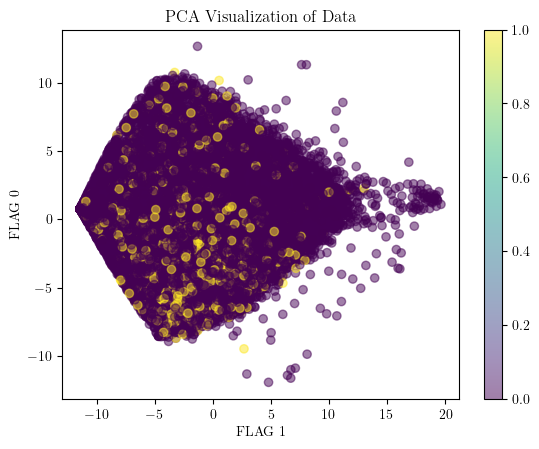

In [125]:
# Performing PCA to reduce the dimensionality of x for visualization
pca = PCA(n_components=2)
x_pca = pca.fit_transform(mData)

# Ensure that the number of labels in y matches the number of data points in x_pca
assert len(x_pca) == len(label), "The number of data points in x_pca does not match the number of labels in y."

# Plotting the reduced x in 2D
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=label, cmap='viridis', alpha=0.5)
plt.xlabel('FLAG 1')
plt.ylabel('FLAG 0')
plt.title('PCA Visualization of Data')
plt.colorbar()
plt.show()

In [ ]:
# cleaned_df = pd.read_csv('../data/processed_data_H.csv')
# cleaned_df.drop(['Unnamed: 0'], axis=1, inplace=True)
# cleaned_df

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


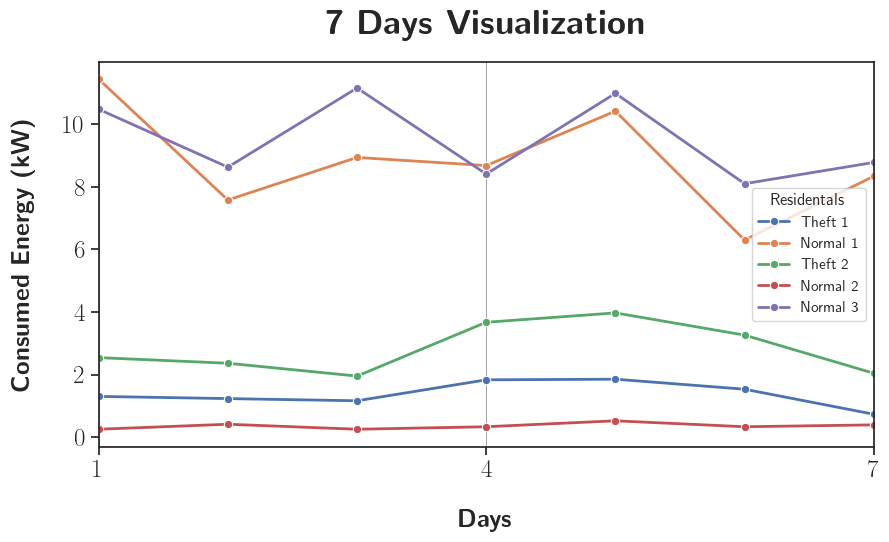

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})

# rows = [cleaned_df.iloc[0, 0:28] for _ in range(5)]
# Assuming df is your DataFrame and you want to visualize the first row
rows = cleaned_df.iloc[[7, 2590, 10, 3617, 26723], 301:308]
# rows = [cleaned_df.iloc[2609, 0+28*i:28*i+28] for i in range(1, 10)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 8)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["Theft 1" for _ in range(7)], ["Normal 1" for _ in range(7)], ["Theft 2" for _ in range(7)], ["Normal 2" for _ in range(7)], ["Normal 3" for _ in range(7)]]).flatten().tolist()
})


# Set a theme
# sns.axes_style()
sns.set_theme(style="ticks")

# Create a lineplot
plt.figure(figsize=(10, 5))

sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o')

# Define the markers
# markers = ['o', 'v', '^', '<', '>']

# Get the unique residentals
# residentals = data['Residentals'].unique()

# Create a lineplot for each residental
# for i, residental in enumerate(residentals):
#     df_residental = data[data['Residentals'] == residental]
#     sns.lineplot(x='Day', y='Value', data=df_residental, marker=markers[i % len(markers)], linewidth=2)

# Add title and labels
plt.title(r'\textbf{7 Days Visualization}', fontsize=25, pad=20)
plt.xlabel(r'\textbf{Days}', fontsize=18, labelpad=20)
plt.ylabel(r'\textbf{Consumed Energy (kW)}', fontsize=18, labelpad=20)

# Set xticks to only show the first and last day
plt.xticks([0, 1, 4, 7], fontsize=18)
plt.yticks(fontsize=18)

# Get the current axes, enabling you to manipulate its properties
ax = plt.gca()

# Display only vertical gridlines
ax.grid(True, which='both', axis='x', color='gray', linewidth=0.5)

# Set x-axis limits
plt.xlim(1, 7)

# Show the plot
plt.show()

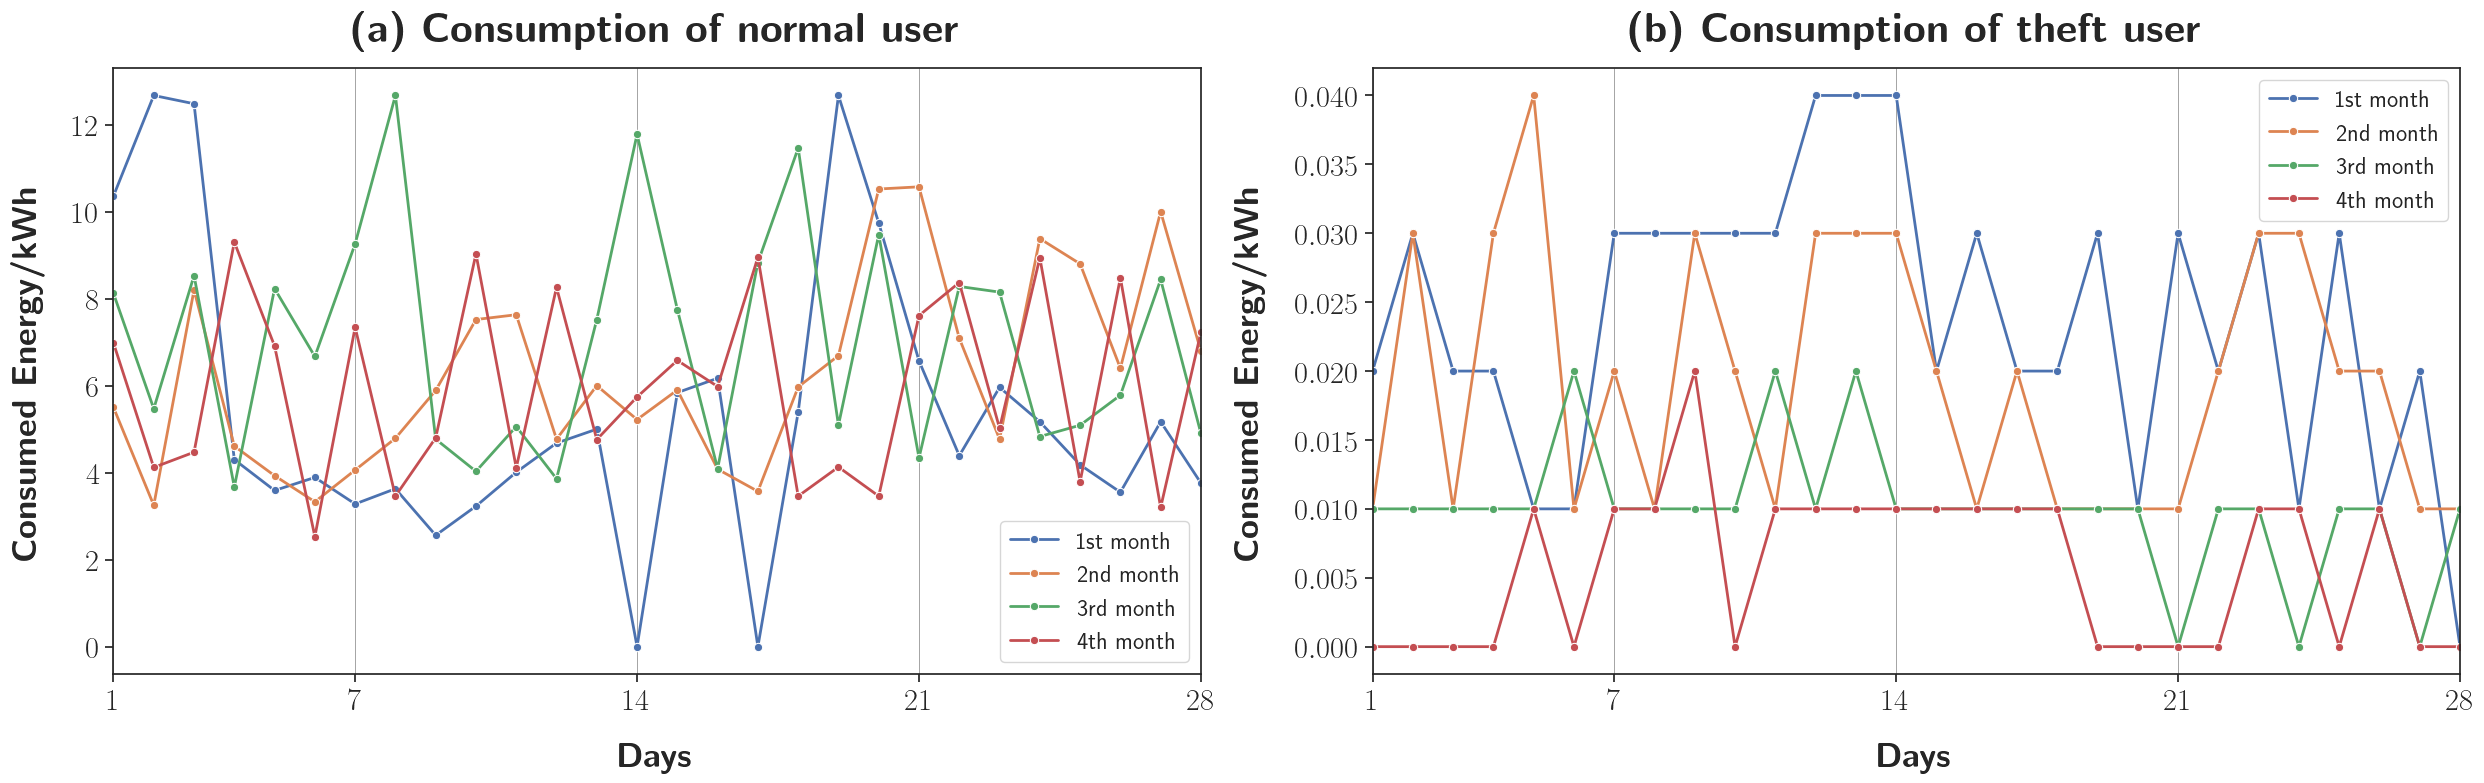

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

sns.set_theme(style="ticks")

# Assuming df is your DataFrame and you want to visualize the first row
rows = [cleaned_df.iloc[8976, 0+28*i:28*i+28] for i in range(1, 5)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 29)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["1st month" for _ in range(28)], ["2nd month" for _ in range(28)], ["3rd month" for _ in range(28)], ["4th month" for _ in range(28)]]).flatten().tolist()
})

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

# Create the first lineplot
sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o', ax=axs[0])
axs[0].set_title(r'\textbf{(a) Consumption of normal user}', fontsize=30, pad=20)
axs[0].set_xlabel(r'\textbf{Days}', fontsize=25, labelpad=20)
axs[0].set_ylabel(r'\textbf{Consumed Energy/kWh}', fontsize=25, labelpad=20)
axs[0].set_xticks([0, 1, 7, 14, 21, 28])
axs[0].tick_params(axis='both', which='major', labelsize=22) 
axs[0].grid(True, which='both', axis='x', color='gray', linewidth=0.5)
axs[0].set_xlim(1, 28)
axs[0].legend(fontsize='x-large')  # Change font size of legend

# Assuming df is your DataFrame and you want to visualize the first row
rows = [cleaned_df.iloc[100, 0+28*i:28*i+28] for i in range(1, 5)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 29)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["1st month" for _ in range(28)], ["2nd month" for _ in range(28)], ["3rd month" for _ in range(28)], ["4th month" for _ in range(28)]]).flatten().tolist()
})

# Create the second lineplot
# (replace 'data2' with your second DataFrame)
sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o', ax=axs[1])
axs[1].set_title(r'\textbf{(b) Consumption of theft user}', fontsize=30, pad=20)
axs[1].set_xlabel(r'\textbf{Days}', fontsize=25, labelpad=20)
axs[1].set_ylabel(r'\textbf{Consumed Energy/kWh}', fontsize=25, labelpad=20)
axs[1].set_xticks([0, 1, 7, 14, 21, 28])
axs[1].tick_params(axis='both', which='major', labelsize=22) 
axs[1].grid(True, which='both', axis='x', color='gray', linewidth=0.5)
axs[1].set_xlim(1, 28)
axs[1].legend(fontsize='x-large')  # Change font size of legend

# Show the plot
plt.tight_layout()
plt.show()

# Non sampling training

In [ ]:
H_dataset = pd.read_csv('../data/processed_data_H.csv').drop(['Unnamed: 0'], axis=1)
H_dataset

# D_dataset = pd.read_csv('../data/best_processed_data.csv')
# D_dataset

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [ ]:
# flag = pd.read_csv('../data/new_info2.csv')
# flag.drop(['Unnamed: 0'], axis=1, inplace=True)
# flag

In [ ]:
# df_combined = pd.concat([flag, H_dataset], axis=1)
# df_combined

In [27]:
# sampling_df_train = train_reduced_df.copy(deep=True)
# sampling_df_val = val_reduced_df.copy(deep=True)
sampling_df = df_outliers_handled.copy(deep=True)

sampling_df

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00,2016-11-01 00:00:00,2016-11-02 00:00:00,label
0,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,6.11,6.10,6.73,7.52,10.89,9.86,8.72,8.72,8.72,1
1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,2.12,1.55,1.18,1.13,1.34,1.26,1.40,1.40,1.40,1
2,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.97,2.79,3.82,2.75,2.96,3.67,2.91,2.91,2.91,1
3,5.20,2.35,2.56,1.46,2.04,5.38,2.73,0.16,3.28,8.03,...,8.81,10.24,15.89,13.00,14.80,14.91,9.03,9.03,9.03,1
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,23.26,24.57,24.25,0.00,23.79,20.93,20.59,25.95,18.52,19.00,...,8.40,10.21,8.61,7.03,8.41,9.84,8.69,8.69,8.69,0
15416,36.35,6.72,4.41,1.26,0.00,0.00,0.00,0.00,0.00,0.00,...,29.86,32.41,35.18,38.41,26.18,30.13,33.64,33.64,33.64,0
15417,2.03,2.82,1.93,2.13,1.81,2.91,1.73,1.53,1.93,1.32,...,2.05,2.80,2.29,2.22,2.34,2.52,1.84,1.84,1.84,0
15418,5.22,5.04,4.92,4.88,13.59,10.73,4.80,6.34,7.07,0.00,...,10.11,9.22,6.78,7.83,14.42,9.58,8.65,8.65,8.65,0


In [29]:
# x = sampling_df.iloc[:, 2:].values
# y = sampling_df.iloc[:, 0].values

# y = sampling_df['label'].values
# x = sampling_df.drop(['label'], axis=1).values

# y_train = train_label.values
# x_train = sampling_df_train.values

# y_val = val_label.values
# x_val = sampling_df_val.values

resample_train = pd.DataFrame(X_resampled_enn)
print(resample_train.shape)

resample_val = pd.DataFrame(X_val)
print(resample_val.shape)

# resample_df = pd.DataFrame(x)
# print(resample_df.shape)

(36938, 1034)
(6324, 1034)


In [50]:
#df_pr['data'] = df_pr[df_pr.columns].astype(float).values.tolist()

df_apr_train = pd.DataFrame({'data': resample_train.values.tolist()})
print(df_apr_train.shape)

df_apr_val = pd.DataFrame({'data': resample_val.values.tolist()})
print(df_apr_val.shape)

# resample_df['data'] = resample_df[resample_df.columns].values.tolist()
# df_apr = resample_df['data']
# print(df_apr.shape)
df_apr_train

(36938, 1)
(6324, 1)


,data
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.77, 0.77, 0.68, 0.01, 0.1, 0.03, 0.09, 0.04..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[9.69, 10.49, 14.26, 10.24, 8.74, 6.64, 6.41, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
36933,"[0.5778047748402984, 2.2223260570780705, 2.435..."
36934,"[8.730473666486011, 6.378449649686454, 7.34463..."
36935,"[2.207955122863054, 0.0, 0.0, 0.0, 2.567023431..."
36936,"[0.9738017314282904, 0.8814876930609034, 1.900..."


In [57]:
df_apr_train.iloc[0]

data    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 0, dtype: object

In [72]:
import utils

window_size = 28 # 4weeks
output_shape = (1036 // window_size, window_size)
print(output_shape)
strided_size = output_shape[0]
print(strided_size)

# padded_arr = np.pad(arr, (0, 1089 - len(arr)), 'constant')
# matrix1 = padded_arr.reshape(33, 33)

# print(np.arange(20))
# np.lib.stride_tricks.as_strided(np.arange(30), (6,5), (8*5, 8))

def stride(x):
    as_strided = np.lib.stride_tricks.as_strided
    # x = pd.Series(x) # no padding
    print((x).shape)
    if len(x) != 1036:
        last_value = x.iloc[:-1] if len(x) > 0 else 0  # Use iloc to get the last value safely
        print("dasdsada: ", last_value)
        dsadas
        x = np.pad(pd.Series(x), (0, 2), 'constant', constant_values=(last_value, last_value))
    return as_strided(x, output_shape, (8*window_size, 8))

df_apr_train = df_apr_train.apply(stride, axis=1)
df_apr_val = df_apr_val.apply(stride)
# df_apr = df_apr.apply(stride)

df_apr_train

(37, 28)
37
(1,)
dasdsada:  Series([], Name: 0, dtype: object)


NameError: name 'dsadas' is not defined

In [45]:
df_dpr_train = df_apr_train.to_frame()
df_dpr_train['label'] = y_resampled_enn

df_dpr_val = df_apr_val.to_frame()
df_dpr_val['label'] = y_val
# df_dpr = df_apr.to_frame()
# df_dpr['label'] = y

df_dpr_train

,0,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,"[[0.77, 0.77, 0.68, 0.01, 0.1, 0.03, 0.09, 0.0...",0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,"[[9.69, 10.49, 14.26, 10.24, 8.74, 6.64, 6.41,...",0
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
...,...,...
36933,"[[0.5778047748402984, 2.2223260570780705, 2.43...",1
36934,"[[8.730473666486011, 6.378449649686454, 7.3446...",1
36935,"[[2.207955122863054, 0.0, 0.0, 0.0, 2.56702343...",1
36936,"[[0.9738017314282904, 0.8814876930609034, 1.90...",1


In [ ]:
df_dpr_shuffled = df_dpr.sample(frac=1).reset_index(drop=True)
df_dpr_shuffled

In [60]:
data_dir = '../data'
save_file = f'{data_dir}/test_new_outlierway.npz'
print('Saving to: ', save_file)
data = df_dpr_train['data']
label = df_dpr_train['label']
np.savez_compressed(save_file, data=data, label=label)

Saving to:  ../data/test_new_outlierway.npz


In [32]:
data_dir = '../data/non_sampling2/'
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


data, label = df_dpr['data'], df_dpr['label']
print(len(data), len(label))
    
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

for mode in ['train', 'test']:
    if mode == 'train':
        data = X_train
        label = y_train
        save_file = f'{data_dir}/train.npz'
    else:
        data = X_test
        label = y_test
        save_file = f'{data_dir}/val.npz'
    np.savez_compressed(save_file, data=data, label=label)

15420 15420


In [46]:
data_dir = '../data/sampling'

for mode in ['train', 'test']:
    if mode == 'train':
        data = df_dpr_train['data']
        label = df_dpr_train['label']
        save_file = f'{data_dir}/train_smoteen_2.npz'
    else:
        data = df_dpr_val['data']
        label = df_dpr_val['label']
        save_file = f'{data_dir}/val_smoteen_2.npz'
    np.savez_compressed(save_file, data=data, label=label)

KeyError: 'data'

In [302]:
dataloader = np.load(save_file, allow_pickle=True)

df = pd.DataFrame({key: dataloader[key] for key in dataloader.keys()})

df

,data,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
1,"[[0.03, 0.01, 0.01, 0.01, 0.0, 0.01, 0.0, 0.01...",0
2,"[[16.97, 15.08, 15.86, 13.36, 15.19, 13.43, 12...",0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
...,...,...
6301,"[[0.0, 4.15, 0.0, 5.73, 6.8, 8.27, 6.11, 5.69,...",0
6302,"[[5.18, 6.86, 0.0, 0.0, 0.0, 7.54, 5.07, 0.0, ...",0
6303,"[[9.79, 9.63, 7.85, 8.49, 8.75, 8.23, 8.8, 5.9...",0
6304,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [61]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

class Writer:
    def __init__(self, outdir, type_name, start_idx=0,):
        self.outdir = Path(outdir)/ type_name
        self.outdir.mkdir(parents=True, exist_ok=True)
        self.idx = start_idx
    def write(self, X, y):
        save_file = self.outdir / f'{self.idx}.npz'
        np.savez_compressed(save_file, X=X, y=y)
        self.idx += 1
    def start(self):
        print('Start writing to: ', self.outdir)

def write_to_file(writer, X, y):
    writer.start()
    try:
        for xi, yi in tqdm(zip(X, y)):
            writer.write(xi, yi)
    except: return False
    return True

def train_test_split(N, test_fraction):
    """
    Input: 
    N: the size of the dataset
    test_fraction: the portion for test set
    Output:
    Return the index for train, val, and test set
    """
    test_size = int(N * test_fraction)
    indices = np.random.permutation(N) 
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return [train_idx, test_idx]

def create_folder_from_npz_file(out_dir, fn):
    file_name = Path(data_dir) / fn
    print('Loading from: ', file_name)
    df_np = np.load(file_name, allow_pickle=True)
    
    data, label = df_np['data'], df_np['label']
    print(len(data), len(label))
    
    indices_lists = train_test_split(len(data), test_fraction=0.2) 
    prefix = ['train', 'val']
    
    for prefix, indices in zip(prefix, indices_lists):
        print(f'{prefix} size: ', len(indices))
        data_subset = data[indices] 
        label_subset = label[indices]
        out_path = out_dir  
        writer = Writer(outdir=out_path, type_name=f'{prefix}')
        write_to_file(writer, data_subset, label_subset)
    return 'Finished'

np.set_printoptions(suppress=True)

out_dir = '../data/test_new_outlierway/'
create_folder_from_npz_file(out_dir=out_dir, fn='test_new_outlierway.npz')

Loading from:  ../data/test_new_outlierway.npz
29861 29861
train size:  23889
Start writing to:  ../data/test_new_outlierway/train


23889it [00:13, 1808.12it/s]


val size:  5972
Start writing to:  ../data/test_new_outlierway/val


5972it [00:03, 1758.79it/s]


'Finished'

# Additional steps

In [ ]:
minority_data = df_dpr[df_dpr['label'] == 1]
majority_data = df_dpr[df_dpr['label'] == 0]
minority_data.shape, majority_data.shape

((2523, 2), (27840, 2))

In [ ]:
data_dir = '../data'
save_file_minority = f'{data_dir}/minority.npz'
save_file_majority = f'{data_dir}/majority.npz'

print('Saving to: ', save_file_minority)
data = minority_data['data']
label = minority_data['label']
np.savez_compressed(save_file_minority, data=data, label=label)

print('Saving to: ', save_file_majority)
data = majority_data['data']
label = majority_data['label']
np.savez_compressed(save_file_majority, data=data, label=label)


Saving to:  ../data/minority.npz
Saving to:  ../data/majority.npz


In [ ]:
data_dir = '../data'
save_file_train = f'{data_dir}/sm_trans_reimplement_train.npz'
save_file_test = f'{data_dir}/sm_trans_reimplement_test.npz'

print('Saving to: ', save_file_train)
data = df_train['data']
label = df_train['label']
np.savez_compressed(save_file_train, data=data, label=label)

print('Saving to: ', save_file_test)
data = df_test['data']
label = df_test['label']
np.savez_compressed(save_file_test, data=data, label=label)


Saving to:  ../data/sm_trans_reimplement_train.npz
Saving to:  ../data/sm_trans_reimplement_test.npz


In [ ]:
np.random.seed(1999)

class Writer:
    def __init__(self, outdir, type_name, start_idx=0,):
        self.outdir = Path(outdir)/ type_name
        self.outdir.mkdir(parents=True, exist_ok=True)
        self.idx = start_idx
    def write(self, X, y):
        save_file = self.outdir / f'{self.idx}.npz'
        np.savez_compressed(save_file, X=X, y=y)
        self.idx += 1
    def start(self):
        print('Start writing to: ', self.outdir)

def write_to_file(writer, X, y):
    writer.start()
    try:
        for xi, yi in tqdm(zip(X, y)):
            writer.write(xi, yi)
    except: return False
    return True

def create_folder_from_npz_file(out_dir, dir_type, fn):
    file_name = Path(data_dir) / fn
    print('Loading from: ', file_name)
    
    df_np = np.load(file_name, allow_pickle=True)
    print(df_np.files)
    
    data, label = df_np['data'], df_np['label']
    print(len(data), len(label))
    
    # np.set_printoptions(threshold=np.inf)
    # print(data[0])

    out_path = out_dir  
    writer = Writer(outdir=out_path, type_name=f'{dir_type}')
    return write_to_file(writer, data, label)

np.set_printoptions(suppress=True)

out_dir = '../data/smTrainSampling/'
create_folder_from_npz_file(out_dir=out_dir, dir_type='train', fn='sm_trans_reimplement_train.npz')
create_folder_from_npz_file(out_dir=out_dir, dir_type='val', fn='sm_trans_reimplement_test.npz')

Loading from:  ../data/sm_trans_reimplement_train.npz
['data', 'label']
44522 44522
Start writing to:  ../data/smTrainSampling/train


44522it [00:25, 1719.61it/s]


Loading from:  ../data/sm_trans_reimplement_test.npz
['data', 'label']
6073 6073
Start writing to:  ../data/smTrainSampling/val


6073it [00:03, 1633.40it/s]


True

In [ ]:
np.random.seed(0)

class Writer:
    def __init__(self, outdir, type_name, start_idx=0,):
        self.outdir = Path(outdir)/ type_name
        self.outdir.mkdir(parents=True, exist_ok=True)
        self.idx = start_idx
    def write(self, X, y):
        save_file = self.outdir / f'{self.idx}.npz'
        np.savez_compressed(save_file, X=X, y=y)
        self.idx += 1
    def start(self):
        print('Start writing to: ', self.outdir)

def write_to_file(writer, X, y):
    writer.start()
    try:
        for xi, yi in tqdm(zip(X, y)):
            writer.write(xi, yi)
    except: return False
    return True

def train_test_split(N, test_fraction):
    """
    Input: 
    N: the size of the dataset
    test_fraction: the portion for test set
    Output:
    Return the index for train, val, and test set
    """
    test_size = int(N * test_fraction)
    indices = np.random.permutation(N) 
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return [train_idx, test_idx]

def create_folder_from_npz_file(out_dir, fn):
    file_name = Path(data_dir) / fn
    print('Loading from: ', file_name)
    df_np = np.load(file_name, allow_pickle=True)
    
    data, label = df_np['data'], df_np['label']
    print(len(data), len(label))
    
    indices_lists = train_test_split(len(data), test_fraction=0.2) 
    prefix = ['train', 'val']
    
    for prefix, indices in zip(prefix, indices_lists):
        print(f'{prefix} size: ', len(indices))
        data_subset = data[indices] 
        label_subset = label[indices]
        out_path = out_dir  
        writer = Writer(outdir=out_path, type_name=f'{prefix}')
        write_to_file(writer, data_subset, label_subset)
    return 'Finished'

np.set_printoptions(suppress=True)

out_dir = '../data/H_dataset_bestcase/'
create_folder_from_npz_file(out_dir=out_dir, fn='H_dataset.npz')

Loading from:  ../data/H_dataset.npz
31683 31683
train size:  25347
Start writing to:  ../data/H_dataset_bestcase/train


25347it [00:14, 1783.92it/s]


val size:  6336
Start writing to:  ../data/H_dataset_bestcase/val


6336it [00:03, 1828.48it/s]


'Finished'

# Tesing

In [81]:
import os
import numpy as np
import pandas as pd

# Directory containing the .npz files
directory = ['../data/non_ksm_transformer/train', '../data/non_ksm_transformer/val']

# List to hold the data


# Loop through all files in the directory
for dir in directory:
    data_list = []
    label_list = []
    for filename in os.listdir(dir):
        if filename.endswith('.npz'):
            # Load the .npz file
            file_path = os.path.join(dir, filename)
            with np.load(file_path) as data:
                # Assuming the .npz file contains arrays, extract them
                consump = data['X'] 
                label = data['y']
                
                data_list.append(consump.flatten().tolist())
                label_list.append(label.flatten().tolist()[0])
    if 'train' in dir:
        train_data = pd.DataFrame(data_list)
        train_data['label'] = label_list
    else:
        val_data = pd.DataFrame(data_list)
        val_data['label'] = label_list

train_data

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,4.96,4.40,5.68,7.87,5.55,6.62,7.85,0.0,0.0,0
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,1.74,1.91,1.81,2.16,1.89,1.98,1.89,0.0,0.0,0
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,2.37,3.01,2.90,2.88,3.97,2.72,3.25,0.0,0.0,0
3,9.34000,15.16000,14.40000,15.24000,14.63000,13.62000,13.01,15.39000,11.35000,8.08,...,11.86,13.60,17.86,13.38,14.01,11.20,12.91,0.0,0.0,1
4,0.77000,0.77000,0.68000,0.01000,0.10000,0.03000,0.09,0.04000,0.25000,0.84,...,1.27,1.54,1.70,0.98,0.75,1.33,0.56,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25342,0.25000,0.65000,1.53000,5.73000,5.26000,1.60000,0.99,1.18000,0.96000,1.10,...,11.66,11.54,10.69,11.24,11.08,9.14,10.12,0.0,0.0,0
25343,16.37371,16.37371,16.37371,16.37371,16.37371,16.37371,13.22,16.37371,16.37371,16.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,1
25344,3.91000,5.59000,4.50000,5.31000,2.91000,3.98000,3.33,4.22000,6.38000,6.02,...,4.76,3.13,5.95,6.01,3.03,4.49,2.30,0.0,0.0,0
25345,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00,0.00000,0.00000,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.0,0


In [86]:
val_data

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,label
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,132.57,143.01,131.51,131.15,114.89,114.94,114.00,0.0,0.0,1
1,0.03,0.01,0.01,0.01,0.00,0.01,0.00,0.01,0.01,0.01,...,5.12,2.93,3.47,2.69,0.08,0.08,3.84,0.0,0.0,0
2,16.97,15.08,15.86,13.36,15.19,13.43,12.50,14.05,15.00,12.30,...,17.91,19.19,18.06,21.84,20.35,17.41,16.76,0.0,0.0,0
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.95,2.30,2.48,1.86,1.77,2.25,1.80,0.0,0.0,0
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.64,2.07,2.70,2.68,2.15,1.62,1.77,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6331,0.00,4.15,0.00,5.73,6.80,8.27,6.11,5.69,5.61,6.05,...,8.77,10.68,8.42,9.18,8.39,10.20,8.43,0.0,0.0,0
6332,5.18,6.86,0.00,0.00,0.00,7.54,5.07,0.00,7.55,0.00,...,15.15,11.42,12.64,11.80,13.09,8.22,0.00,0.0,0.0,0
6333,9.79,9.63,7.85,8.49,8.75,8.23,8.80,5.91,10.14,8.60,...,6.64,7.10,8.54,7.66,7.27,7.42,6.36,0.0,0.0,0
6334,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.27,0.13,0.26,0.21,0.17,0.26,0.22,0.0,0.0,0
